# Projet_8 : cityscapes dataset

This notebook will contain all exploration regarding the EDA of cityscape dataset, the choice of a model to segment images, and the pipeline to do it

The CityScape dataset contains pre-treated images, so we won't be able to work with the origin images 
We will probably have to augment data 


In [31]:
#librairies
# classic Librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import shutil
from collections import Counter
from collections import namedtuple

from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.model_selection import StratifiedShuffleSplit

import tensorflow as tf
import keras
from keras import backend as K
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm
from segmentation_models import get_preprocessing
import torch
from torch import nn

# image imports
from matplotlib.image import imread
import PIL
from PIL import Image, ImageFilter, ImageEnhance

from tensorflow.keras import layers, models
import tensorflow.keras.backend as K
from keras.metrics import IoU
from tensorflow.keras.metrics import MeanIoU

import albumentations as A
import cv2

Segmentation Models: using `tf.keras` framework.


C:\Users\kanam\anaconda3\Lib\site-packages\albumentations\check_version.py:107: UserWarning: Error fetching version info <urlopen error [Errno 11001] getaddrinfo failed>
  data = fetch_version_info()


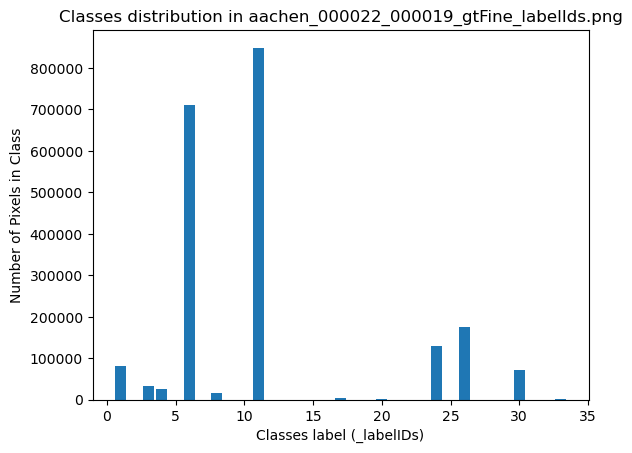

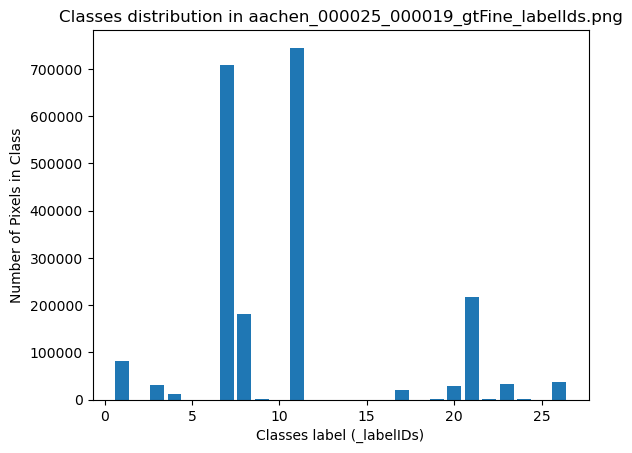

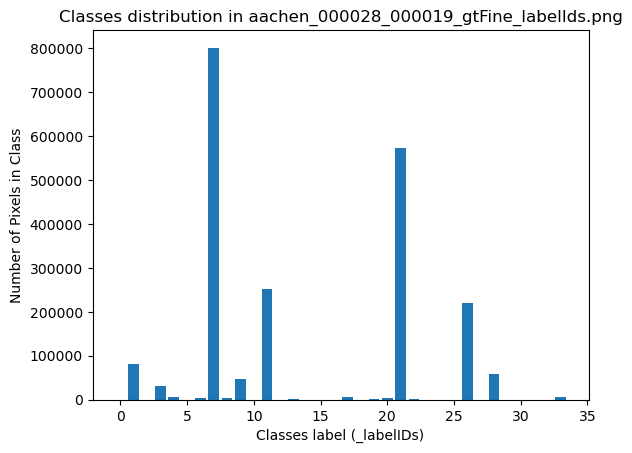

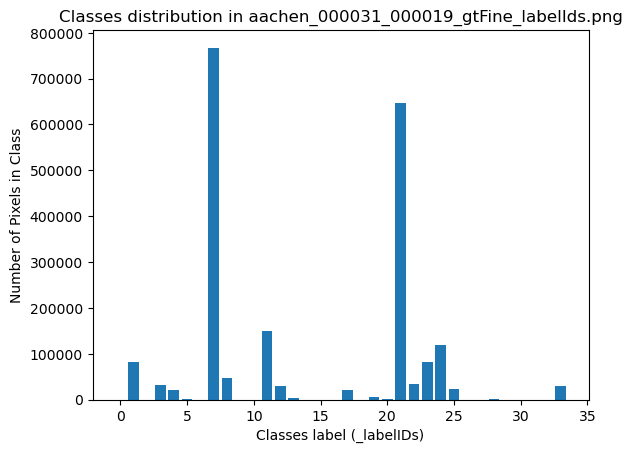

In [32]:
#display class distribution of a few files to ensure results
copies_folder = "data/train/masks"

copied_files = sorted(os.listdir(copies_folder))[:4]

#classes counter
for file in copied_files:
    if file.endswith("_labelIds.png"):
        FILE_PATH = os.path.join(copies_folder, file)
        #print(FILE_PATH)
    
        class_counts = Counter()
    
        mask = cv2.imread(FILE_PATH, cv2.IMREAD_GRAYSCALE)
        class_counts.update(mask.flatten())
        
        plt.bar(class_counts.keys(), class_counts.values())
        plt.xlabel("Classes label (_labelIDs)")
        plt.ylabel("Number of Pixels in Class")
        plt.title(f"Classes distribution in {file}")
        plt.show()
    else:
        print("Raw image, won't display")
    


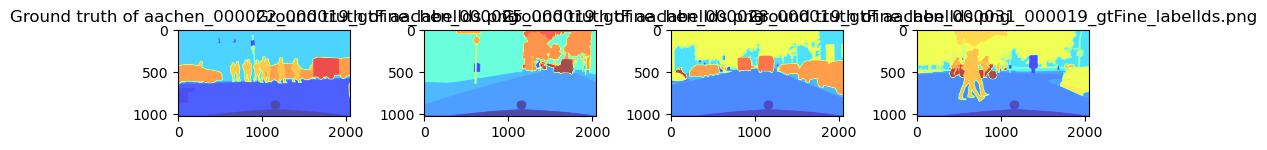

In [33]:
#display raw image and ground truth
fig, axes = plt.subplots(1, len(copied_files), figsize=(10, 20))

for i, file in enumerate(copied_files):
    FILE_PATH = os.path.join(copies_folder, os.path.basename(file))
    if file.endswith("_labelIds.png"):
        mask = cv2.imread(FILE_PATH, cv2.IMREAD_GRAYSCALE)
        axes[i].imshow(mask, cmap="jet", alpha=0.7)
        axes[i].set_title(f"Ground truth of {file}")
    else:
        img = Image.open(FILE_PATH)
        axes[i].imshow(img)
        axes[i].set_title(file)
        
    
    #axes[i].axis("off")

plt.tight_layout()
plt.show() 

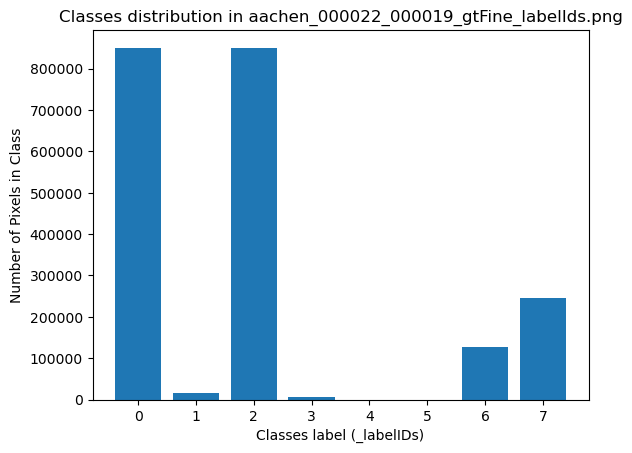

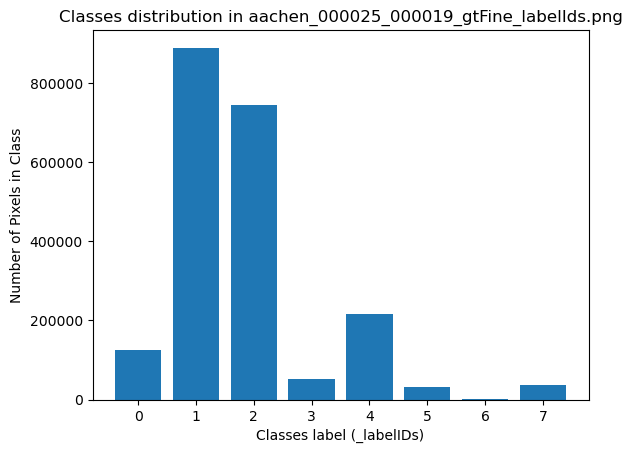

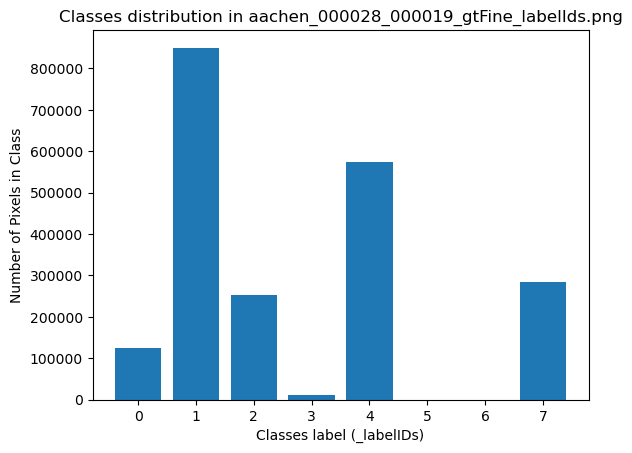

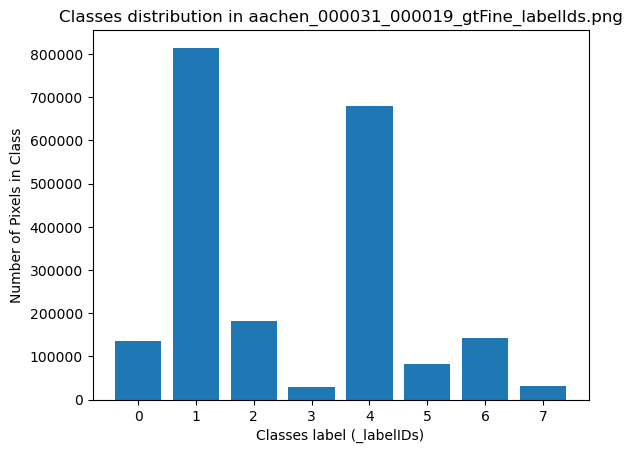

In [34]:
#checking the 4 first elements
output_path = "data/train/gen_masks"
generalized_mask_files = os.listdir(output_path)[:4]

#Generalized classes counter
for mask_file in generalized_mask_files:
    FILE_PATH = os.path.join(output_path, os.path.basename(mask_file))
    #print(FILE_PATH)

    class_counts = Counter()

    mask = cv2.imread(FILE_PATH, cv2.IMREAD_GRAYSCALE)
    class_counts.update(mask.flatten())
    
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel("Classes label (_labelIDs)")
    plt.ylabel("Number of Pixels in Class")
    plt.title(f"Classes distribution in {mask_file}")
    plt.show()

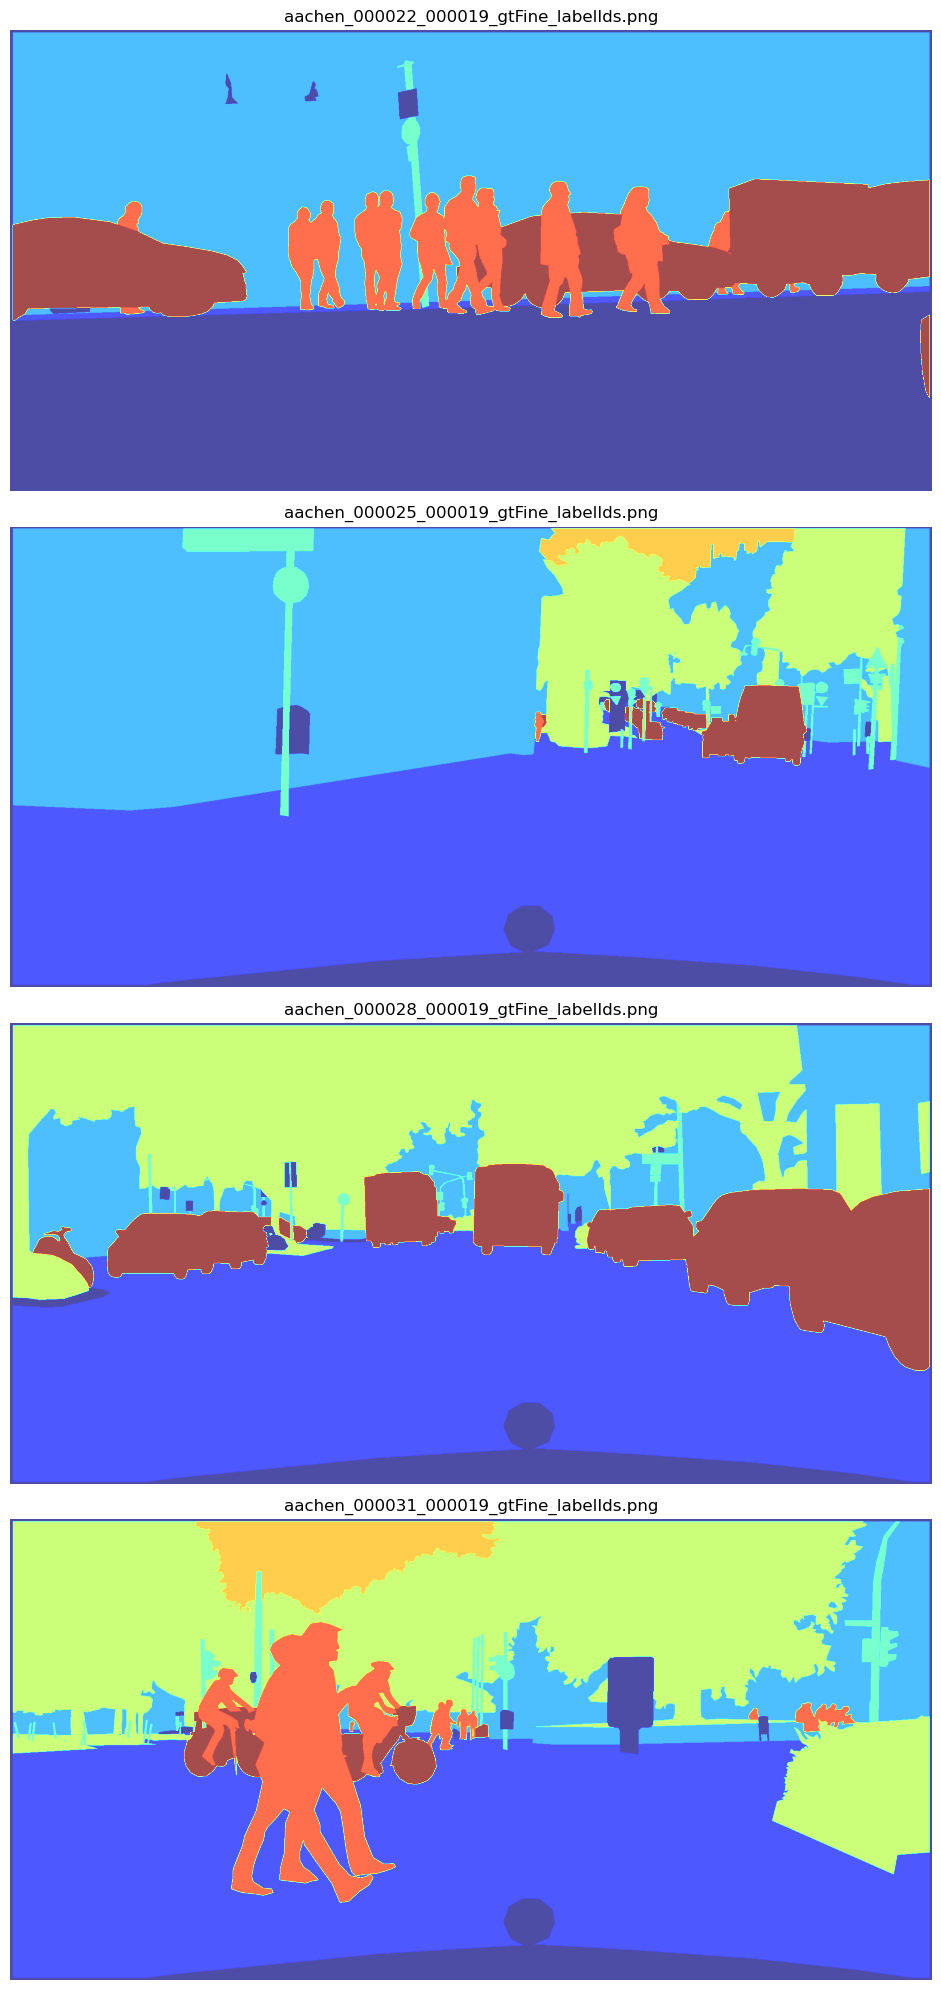

In [35]:
#Display mask
fig, axes = plt.subplots(len(generalized_mask_files), 1, figsize=(10, 20))

for i, mask_file in enumerate(generalized_mask_files):
    FILE_PATH = os.path.join(output_path, os.path.basename(mask_file))
    mask = cv2.imread(FILE_PATH, cv2.IMREAD_GRAYSCALE)
    axes[i].imshow(mask, cmap="jet", alpha=0.7)
    axes[i].set_title(mask_file)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

## EDA

Now that we have generalized our data into 8 classes, we can start investigating

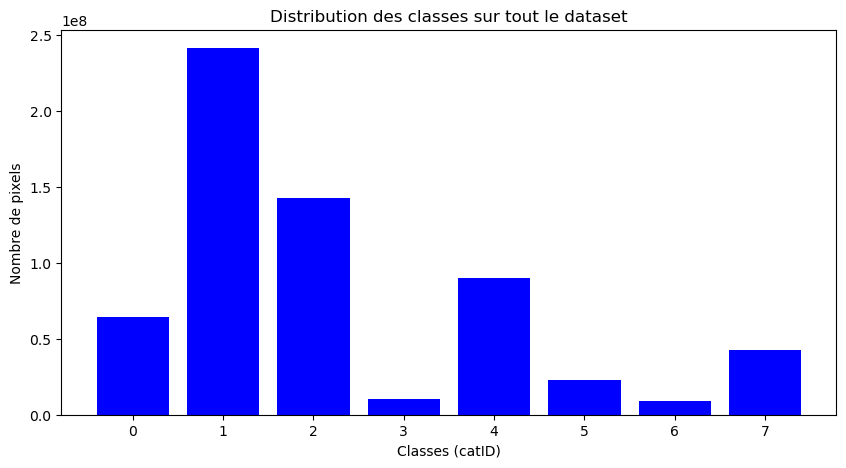

In [37]:
#What class distribution along the dataset pixel-wise ?

# Définition du chemin des masques transformés
generalized_mask_folder = "data/train/gen_masks"

# Initialiser un compteur pour toutes les classes
class_counts = Counter()

# Parcourir toutes les images du dataset
for mask_file in os.listdir(generalized_mask_folder):
    mask_path = os.path.join(generalized_mask_folder, mask_file)

    # Charger le masque en niveaux de gris
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Mettre à jour les comptes des classes
    class_counts.update(mask.flatten())

# Trier les classes par ID pour l'affichage
sorted_class_counts = dict(sorted(class_counts.items()))

# Afficher la distribution sous forme de graphe
plt.figure(figsize=(10, 5))
plt.bar(sorted_class_counts.keys(), sorted_class_counts.values(), color="blue")
plt.xlabel("Classes (catID)")
plt.ylabel("Nombre de pixels")
plt.title("Distribution des classes sur tout le dataset")
plt.xticks(list(sorted_class_counts.keys()))  # Afficher les labels correctement
plt.show()


Classes 3 and 6, "objects" and "human", seems to be the less represented classes. 

This means our problem is an imbalanced one.

We asserted that the classes are rare in pixels. We will now check if they are contained in each images, even if scarcely

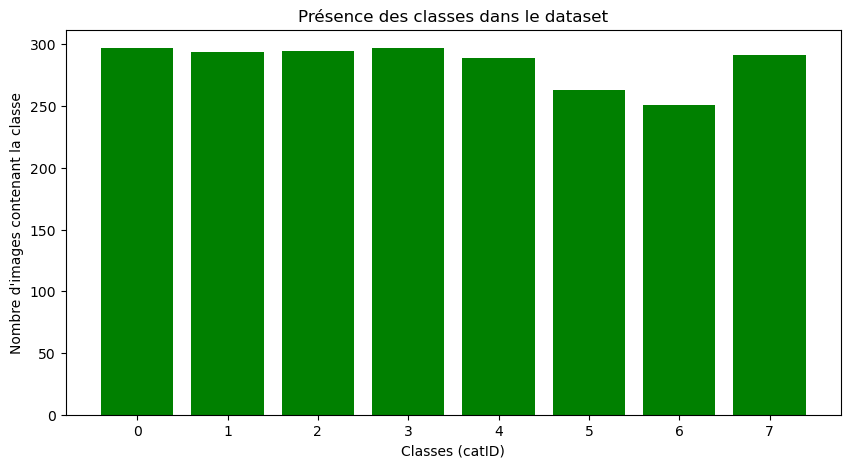

In [39]:
#are there any 'rare classes' in images ? 

# Initialiser un compteur du nombre d'images où chaque classe apparaît
class_presence = Counter()

# Parcourir toutes les images
for mask_file in os.listdir(generalized_mask_folder):
    mask_path = os.path.join(generalized_mask_folder, mask_file)

    # Charger le masque
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Vérifier quelles classes sont présentes dans cette image
    unique_classes = np.unique(mask)
    for cls in unique_classes:
        class_presence[cls] += 1  # Compte combien d'images contiennent cette classe

# Trier les classes par fréquence
sorted_class_presence = dict(sorted(class_presence.items()))

# Affichage
plt.figure(figsize=(10, 5))
plt.bar(sorted_class_presence.keys(), sorted_class_presence.values(), color="green")
plt.xlabel("Classes (catID)")
plt.ylabel("Nombre d'images contenant la classe")
plt.title("Présence des classes dans le dataset")
plt.xticks(list(sorted_class_presence.keys()))
plt.show()


Human seem to be the rarest class, which is not a good news, since the model could become blind to them.

The biggest issue here is that "human" pixels are the rarest class in image, and even then are scarce when present

We will have to DataAugment our training set to have them more present, probably centered towards them

will prepare the same split for validation and test sets

In [42]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K

print("TensorFlow version:", tf.__version__)
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.17.0
GPUs disponibles: []


In [25]:
#dataset

### Model exploration with Segmentation_Models

Segmentation_model will provide the UNet architecture and also allow us to test different backbones.

In [44]:
#using https://github.com/qubvel/segmentation_models

In [45]:
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

In [46]:
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss, cce_jaccard_loss
from segmentation_models.metrics import iou_score

In [47]:
#loader function
def load_data(image_dir, mask_dir, img_size=(512, 512), num_classes=8):
    all_images = os.listdir(image_dir)
    all_masks = os.listdir(mask_dir)
    images = []
    masks = []
    
    for img_name in all_images:
        img_path = os.path.join(image_dir, img_name)

        # Load and resize images
        image = cv2.imread(img_path)
        image = cv2.resize(image, img_size)
        images.append(image)
        
    for mask_name in all_masks:
        mask_path = os.path.join(mask_dir, mask_name)
        
        # Load and resize masks
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask as grayscale
        mask = cv2.resize(mask, img_size)

        # One-hot encode the mask
        mask_one_hot = np.zeros((img_size[0], img_size[1], num_classes))
        for i in range(num_classes):
            mask_one_hot[:, :, i] = (mask == i).astype(int)
        masks.append(mask_one_hot)

    images = np.array(images) / 255 # Normalize images
    masks = np.array(masks)  # Masks are already in one-hot format
    
    return images, masks


In [48]:
#importing custom metrics
from metrics_and_loss import CombinedLoss, M_IoUMetric
combined_loss = CombinedLoss(smooth=100, alpha=0.5)

In [49]:
#add this to function to avoid taking .ipynb files into account with os.listdir
"""img_list = []
for i in os.listdir(image_dir_train):
    if i.endswith('.png'):
        img_list.append(i)
for img_name in img_list:
    img_path = os.path.join(image_dir_train, img_name)

    # Load and resize images
    image = cv2.imread(img_path)
    print(img_path)
    #image = cv2.resize(image, (512, 512))"""

"img_list = []\nfor i in os.listdir(image_dir_train):\n    if i.endswith('.png'):\n        img_list.append(i)\nfor img_name in img_list:\n    img_path = os.path.join(image_dir_train, img_name)\n\n    # Load and resize images\n    image = cv2.imread(img_path)\n    print(img_path)\n    #image = cv2.resize(image, (512, 512))"

In [50]:
#load images and check shape (train set)
image_dir_train = 'data/train/images'
mask_dir_train = 'data/train/gen_masks'
X_train, y_train = load_data(image_dir_train, mask_dir_train, img_size=(512, 512), num_classes=8)
X_train.shape

(297, 512, 512, 3)

In [51]:
#same for val set
image_dir_val = 'data/val/images'
mask_dir_val = 'data/val/gen_masks'
X_val, y_val = load_data(image_dir_val, mask_dir_val, num_classes=8)
X_val.shape

(50, 512, 512, 3)

In [52]:
# define an early stop to avoid overfitting
EarlyStop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    start_from_epoch=0
)

#### 1st MODEL : VGG16 Backbone (will act as a baseline)

In [54]:
#Backbone selection
BACKBONE = 'vgg16'
preprocess_input = get_preprocessing(BACKBONE)

#preprocess_input = get_preprocessing(BACKBONE)
#X_train = preprocess_input(X_train)
#X_val = preprocess_input(X_val)
#IoU_score = IoU(num_classes=8, target_class_ids=[0,1,2,3,4,5,6,7]) #Keras native
#IoU_score = iou_score #from segmentation_models but can't be serialized
M_IoU_score = M_IoUMetric() #custom IoU

model = sm.Unet(BACKBONE, input_shape=(512, 512, 3), encoder_weights='imagenet', classes=8, activation='softmax')
model.compile(optimizer='adam', loss=combined_loss, metrics=[M_IoU_score, 'accuracy'])

https://www.scitepress.org/PublishedPapers/2021/103040/103040.pdf

Paper seems to indicate the importance and relevance of PowerJaccardLoss with p=2 on Cityscape dataset \
How to implement it ?

In [56]:
# fit model
t0 = time.time()

model.fit(
    x=X_train,
    y=y_train,
    batch_size=16,
    epochs=100,
    callbacks=EarlyStop,
    validation_data=(X_val, y_val)
)

t1 = time.time() - t0
print("Took", t1, "seconds")
vgg16_train_time = t1

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 908s 46s/step - accuracy: 0.4467 - iou: 0.1408 - loss: 45.7347 - val_accuracy: 0.1657 - val_iou: 0.0904 - val_loss: 87.4615
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 906s 46s/step - accuracy: 0.7381 - iou: 0.5870 - loss: 36.1005 - val_accuracy: 0.1029 - val_iou: 0.0522 - val_loss: 53.8699
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 922s 46s/step - accuracy: 0.7995 - iou: 0.6679 - loss: 29.5971 - val_accuracy: 0.2230 - val_iou: 0.1201 - val_loss: 46.0294
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 870s 46s/step - accuracy: 0.8133 - iou: 0.6864 - loss: 27.0930 - val_accuracy: 0.3632 - val_iou: 0.2116 - val_loss: 43.8783
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 915s 45s/step - accuracy: 0.8331 - iou: 0.7145 - loss: 25.2391 - val_accuracy: 0.5306 - val_iou: 0.3506 - val_loss: 40.0297
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 930s 46s/step - accuracy: 0.8406 - iou: 0.7256 - loss: 24.7831 - val_accuracy: 0.6490 - val_iou: 0.4805 - val_loss: 36.9326
Epoch 7/100
19/19 ━━━━

In [57]:
#prep the prediction
test_images_path = "data/test/images"
test_masks_path = "data/test/gen_masks"

X_test, y_test = load_data(test_images_path, test_masks_path)
X_test.shape

(153, 512, 512, 3)

In [58]:
#prediction of trained model
prediction = model.predict(X_test, batch_size=16, verbose=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 106s 10s/step


In [59]:
# Définir une palette de couleurs personnalisée pour 8 classes
colors = np.array([[128, 0, 128],     # Violet #"void"
                   [255, 0, 255],     # Magenta #"flat"
                   [0, 0, 255],       # Bleu #"construction"
                   [255, 255, 0],     # Jaune #"object"
                   [0, 255, 0],       # Vert #"nature"
                   [0, 255, 255],     # Cyan #"sky"
                   [255, 0, 0],       # Rouge #"human"
                   [255, 165, 0]],    # Orange #"vehicle"
                  dtype=np.uint8)


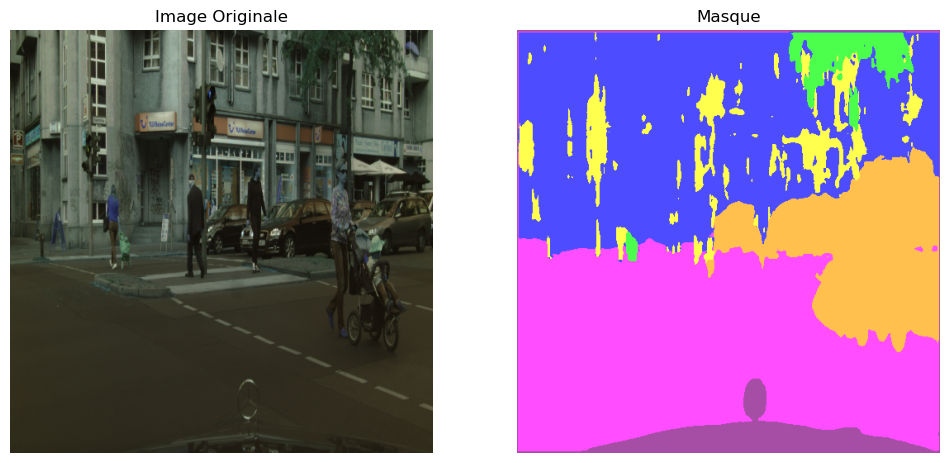

In [60]:
# for i the index of image to check
i = 1
mask_array = prediction[i]

# Charger l'image originale avec OpenCV
original_image_path = os.path.join(test_images_path,os.listdir(test_images_path)[i])
original_image = cv2.imread(original_image_path)

#convert image to mask size
original_image = cv2.resize(original_image, (512, 512))

# Convertir le masque à 8 canaux en masque d'index
mask_channel = (mask_array * 255).astype(np.uint8) #prepare for individual inspection
mask_index = np.argmax(mask_array, axis=-1) 
# Convertir le masque en image OpenCV
mask_image = (mask_index * 255).astype(np.uint8) 

#convert mask to original dimensions
#mask_image = cv2.resize(mask_image, (2048, 1024))

# Créer un masque couleur en utilisant la palette
mask_color = colors[mask_index]

# Afficher les images côte à côte avec Matplotlib
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Afficher l'image originale à droite
axes[0].imshow(original_image)
axes[0].set_title("Image Originale")
axes[0].axis('off')

# Afficher le masque à gauche
#axes[1].imshow(mask_channel[:,:,6], cmap='jet', alpha=0.7) #individual inspection
axes[1].imshow(mask_color, alpha=0.7) #whole mask
axes[1].set_title("Masque")
axes[1].axis('off')

plt.show()

Seems to predict class 5 everywhere. Class 5 is the "sky" class. Our model is overfit to this class ? 

After further training, model seems to react better

In [62]:
model.evaluate(X_val, y_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 35s 12s/step - accuracy: 0.8664 - iou: 0.7646 - loss: 20.5005


[20.229248046875, 0.7749502062797546, 0.8730527758598328]

Had excellent results with segmentation_model metrics and losses, but now it's bad

In [64]:
#saving model
model.save('models_in_progress/first_model.keras')  # The file needs to end with the .keras extension
#load model
#model = keras.models.load_model('models_in_progress/first_model.keras')

In [65]:
#don't forget I'll need to import my metrics_and_loss.py when I want to load it somewhere else !
my_model = keras.models.load_model('models_in_progress/first_model.keras')

In [66]:
my_model.evaluate(X_val, y_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 12s/step - accuracy: 0.8664 - iou: 0.7646 - loss: 20.5005


[20.229248046875, 0.7749502062797546, 0.8730527758598328]

In [ ]:
# clearing graph to avoid training on precedent TF.graph free memory
# K.clear_session() IS NOT ENOUGH ! 
# https://stackoverflow.com/questions/58453793/the-clear-session-method-of-keras-backend-does-not-clean-up-the-fitting-data
del model
K.clear_session()
tf.compat.v1.reset_default_graph()
#reset_seeds()

#### 2nd MODEL : Same backbone / different LR 

In [70]:
# model prep
model2 = sm.Unet(BACKBONE, input_shape=(512, 512, 3), encoder_weights='imagenet', classes=8, activation='softmax')
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=combined_loss, metrics=[M_IoU_score, 'accuracy'])

In [71]:
t0 = time.time()

model2.fit(
    x=X_train,
    y=y_train,
    batch_size=16,
    epochs=100,
    callbacks = EarlyStop,
    validation_data=(X_val, y_val)
)

t1 = time.time() - t0
print("Took", t1, "seconds")
vgg16_lower_LR_train_time = t1

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 913s 46s/step - accuracy: 0.3140 - iou: 0.2469 - loss: 47.9072 - val_accuracy: 0.1123 - val_iou: 0.0538 - val_loss: 49.0041
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 875s 46s/step - accuracy: 0.5269 - iou: 0.0657 - loss: 45.7286 - val_accuracy: 0.2074 - val_iou: 0.1008 - val_loss: 47.0203
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 872s 46s/step - accuracy: 0.6916 - iou: 0.3157 - loss: 42.7713 - val_accuracy: 0.5383 - val_iou: 0.0817 - val_loss: 45.2961
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 871s 46s/step - accuracy: 0.8068 - iou: 0.4711 - loss: 39.8713 - val_accuracy: 0.6864 - val_iou: 0.2299 - val_loss: 43.5432
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 870s 46s/step - accuracy: 0.8534 - iou: 0.6722 - loss: 36.9190 - val_accuracy: 0.7234 - val_iou: 0.3524 - val_loss: 42.4580
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 871s 46s/step - accuracy: 0.8620 - iou: 0.7456 - loss: 34.2689 - val_accuracy: 0.7986 - val_iou: 0.4824 - val_loss: 41.0587
Epoch 7/100
19/19 ━━━━

In [72]:
#prediction of trained model
prediction2 = model2.predict(X_test, batch_size=16, verbose=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 108s 10s/step


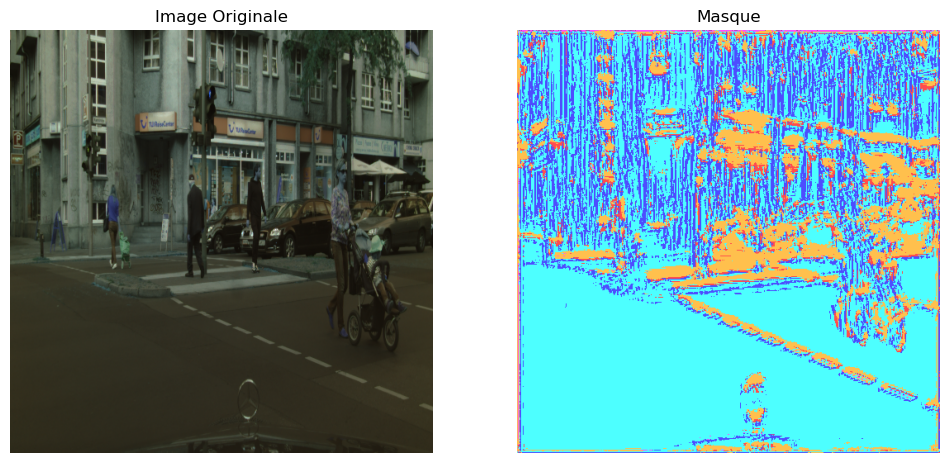

In [73]:
# for i the index of image to check
i = 1
mask_array = prediction2[i]

# Charger l'image originale avec OpenCV
original_image_path = os.path.join(test_images_path,os.listdir(test_images_path)[i])
original_image = cv2.imread(original_image_path)

#convert image to mask size
original_image = cv2.resize(original_image, (512, 512))

# Convertir le masque à 8 canaux en masque d'index
mask_channel = (mask_array * 255).astype(np.uint8) #prepare for individual inspection
mask_index = np.argmax(mask_array, axis=-1) 
# Convertir le masque en image OpenCV
mask_image = (mask_index * 255).astype(np.uint8) 

#convert mask to original dimensions
#mask_image = cv2.resize(mask_image, (2048, 1024))

# Créer un masque couleur en utilisant la palette
mask_color2 = colors[mask_index]

# Afficher les images côte à côte avec Matplotlib
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Afficher l'image originale à droite
axes[0].imshow(original_image)
axes[0].set_title("Image Originale")
axes[0].axis('off')

# Afficher le masque à gauche
#axes[1].imshow(mask_channel[:,:,6], cmap='jet', alpha=0.7) #individual inspection
axes[1].imshow(mask_color2, alpha=0.7) #whole mask
axes[1].set_title("Masque")
axes[1].axis('off')

plt.show()

In [74]:
model2.evaluate(X_val, y_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 35s 12s/step - accuracy: 0.1116 - iou: 0.0535 - loss: 49.0404


[49.004127502441406, 0.05383491888642311, 0.11228683590888977]

Interesting results ... maybe modify the loss function ? try a mix of categoricalcross entropy and Focal_jaccard ?

In [76]:
model2.save('models_in_progress/second_model.keras')

In [77]:
# clearing graph to avoid training on precedent TF.graph free memory
# K.clear_session() IS NOT ENOUGH ! 
del model2
K.clear_session()
tf.compat.v1.reset_default_graph()
#reset_seeds()

In [78]:
"""
#free memory
from keras import backend as K
K.clear_session()
#CLEAR SESSION IS NOT ENOUGH ! 

reset_seeds()
model = make_model() # example function to instantiate model
model.fit(x_good, y_good)

del model
K.clear_session()
tf.compat.v1.reset_default_graph()

reset_seeds()
model = make_model()
model.fit(x_bad, y_bad)
"""

'\n#free memory\nfrom keras import backend as K\nK.clear_session()\n#CLEAR SESSION IS NOT ENOUGH ! \n\nreset_seeds()\nmodel = make_model() # example function to instantiate model\nmodel.fit(x_good, y_good)\n\ndel model\nK.clear_session()\ntf.compat.v1.reset_default_graph()\n\nreset_seeds()\nmodel = make_model()\nmodel.fit(x_bad, y_bad)\n'

In [79]:
#using https://github.com/JanMarcelKezmann/TensorFlow-Advanced-Segmentation-Models/

In [80]:
#using https://github.com/zhixuhao/unet

In [81]:
# pushing further in https://encord.com/blog/github-repositories-image-segmentation/

In [82]:
# exploreing power jaccard : https://www.scitepress.org/PublishedPapers/2021/103040/103040.pdf

Piste 1 : récupérer les poids d'entrainement de cityscape directement ? trouver un modèle déjà entrainé \
Piste 1.5 : expérimenter avec un autre Backbone ? Xception ? Vggnet mini ? Resnet50 ? \
Piste 2 : data-augment => gagner du temps / gagner en efficacité \
Montrer qu'on est capable mais rappeler que la data-augment prend du temps \
! Justifier l'augment de data => CHOISIR des données où les classes sont présent et augmenter celles ci \
! Simuler des conditions météo \
SINON augmenter le pourcentage de data choisi 

Piste 3 : Dériver l'entrainement vers GPU pour améliorer le traitement de l'image \


! Mettre dans la note technique la différence de traitement par CPU et par GPU !


#### 3rd MODEL : ResNet50 BACKBONE

In [85]:
#RESNET50
BACKBONE = 'resnet50'
preprocess_input = get_preprocessing(BACKBONE)

#model with CatCross+Jaccard Loss
model_resnet = sm.Unet(BACKBONE, input_shape=(512, 512, 3), encoder_weights='imagenet', classes=8, activation='softmax')
model_resnet.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=combined_loss, metrics=[M_IoU_score, 'accuracy'])

In [86]:
#model fit
t0 = time.time()

model_resnet.fit(
    x=X_train,
    y=y_train,
    batch_size=16,
    epochs=100,
    callbacks = EarlyStop,
    validation_data=(X_val, y_val)
)

t1 = time.time() - t0
print("Took", t1, "seconds")
resnet_train_time = t1

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 523s 24s/step - accuracy: 0.2920 - iou: 0.0790 - loss: 46.7777 - val_accuracy: 0.1719 - val_iou: 0.0000e+00 - val_loss: 48.4718
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 438s 23s/step - accuracy: 0.6858 - iou: 0.3395 - loss: 42.0538 - val_accuracy: 0.1416 - val_iou: 0.0280 - val_loss: 48.0198
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 436s 23s/step - accuracy: 0.7998 - iou: 0.4132 - loss: 39.6747 - val_accuracy: 0.3683 - val_iou: 0.0623 - val_loss: 47.1546
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 435s 23s/step - accuracy: 0.8429 - iou: 0.4463 - loss: 37.9627 - val_accuracy: 0.3120 - val_iou: 0.0830 - val_loss: 47.2584
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 434s 23s/step - accuracy: 0.8617 - iou: 0.4591 - loss: 36.4890 - val_accuracy: 0.4284 - val_iou: 0.0726 - val_loss: 47.2204
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 434s 23s/step - accuracy: 0.8694 - iou: 0.4789 - loss: 35.0835 - val_accuracy: 0.4488 - val_iou: 0.0521 - val_loss: 47.2215
Epoch 7/100
19/19 

In [87]:
prediction_resnet = model_resnet.predict(X_test, batch_size=16, verbose=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 64s 6s/step


In [88]:
model_resnet.save('models_in_progress/resnet_model.keras')

In [89]:
# clearing graph to avoid training on precedent TF.graph free memory
# K.clear_session() IS NOT ENOUGH ! 
del model_resnet
K.clear_session()
tf.compat.v1.reset_default_graph()
#reset_seeds()

#### 4th MODEL : inceptionv3 BACKBONE

In [91]:
#Inception
BACKBONE = 'inceptionv3'
preprocess_input = get_preprocessing(BACKBONE)

#EarlyStop function
EarlyStop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    start_from_epoch=0
)

model_inception = sm.Unet(BACKBONE, input_shape=(512, 512, 3), encoder_weights='imagenet', classes=8, activation='softmax')
model_inception.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=combined_loss, metrics=[M_IoU_score, 'accuracy'])

In [92]:
#model fit
t0 = time.time()

model_inception.fit(
    x=X_train,
    y=y_train,
    batch_size=16,
    epochs=100,
    callbacks = EarlyStop,
    validation_data=(X_val, y_val)
)

t1 = time.time() - t0
print("Took", t1, "seconds")
inceptionv3_train_time = t1

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 467s 20s/step - accuracy: 0.1179 - iou: 0.0296 - loss: 48.1499 - val_accuracy: 0.1210 - val_iou: 0.0496 - val_loss: 47.2565
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 363s 19s/step - accuracy: 0.4728 - iou: 0.1324 - loss: 44.4894 - val_accuracy: 0.3287 - val_iou: 0.1018 - val_loss: 44.9609
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 365s 19s/step - accuracy: 0.6962 - iou: 0.2504 - loss: 41.7878 - val_accuracy: 0.4702 - val_iou: 0.3395 - val_loss: 41.0839
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 361s 19s/step - accuracy: 0.8056 - iou: 0.3510 - loss: 39.4013 - val_accuracy: 0.7066 - val_iou: 0.3841 - val_loss: 39.4493
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 389s 19s/step - accuracy: 0.8574 - iou: 0.4351 - loss: 37.1083 - val_accuracy: 0.7968 - val_iou: 0.3854 - val_loss: 38.4973
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 385s 19s/step - accuracy: 0.8807 - iou: 0.6556 - loss: 34.9319 - val_accuracy: 0.8229 - val_iou: 0.6463 - val_loss: 36.7176
Epoch 7/100
19/19 ━━━━

In [93]:
prediction_inception = model_inception.predict(X_test, batch_size=16, verbose=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 64s 6s/step


In [94]:
model_inception.save('models_in_progress/inception_model.keras')

In [95]:
# clearing graph to avoid training on precedent TF.graph free memory
# K.clear_session() IS NOT ENOUGH ! 
del model_inception
K.clear_session()
tf.compat.v1.reset_default_graph()
#reset_seeds()

In [96]:
def prepare_mask_array(mask_array):
    # Convertir le masque à 8 canaux en masque d'index
    mask_channel = (mask_array * 255).astype(np.uint8) #prepare for individual inspection
    mask_index = np.argmax(mask_array, axis=-1) 
    # Convertir le masque en image OpenCV
    #mask_image = (mask_index * 255).astype(np.uint8)
    mask_image = colors[mask_index]
    
    return mask_channel, mask_image

In [98]:
# preparing for visualisation

# reloading all models after deletion
model_VGG16 = keras.models.load_model('models_in_progress/first_model.keras')
model_VGG16_LR = keras.models.load_model('models_in_progress/second_model.keras')
model_ResNet50 = keras.models.load_model('models_in_progress/resnet_model.keras')
model_InceptionV3 = keras.models.load_model('models_in_progress/inception_model.keras')

# reloading all prediction after deletion
prediction = model_VGG16.predict(X_test, batch_size=16, verbose=1)
prediction2 = model_VGG16_LR.predict(X_test, batch_size=16, verbose=1)
prediction_resnet = model_ResNet50.predict(X_test, batch_size=16, verbose=1)
prediction_inception = model_InceptionV3.predict(X_test, batch_size=16, verbose=1)

# now we ready to compare masks !

10/10 ━━━━━━━━━━━━━━━━━━━━ 106s 10s/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 107s 11s/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 64s 6s/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 59s 5s/step


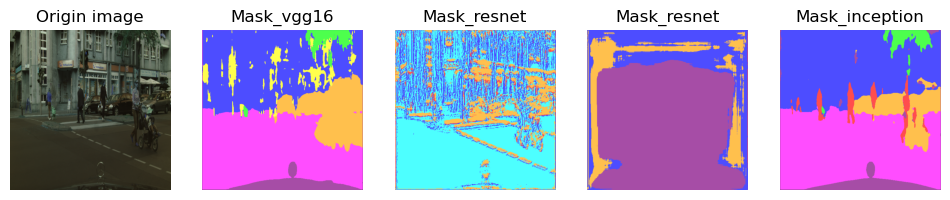

In [99]:
# for i the index of image to check (in the test set)
i = 1
mask_array_vgg16 = prediction[i]
mask_array_vgg16_lowerLR = prediction2[i]
mask_array_resnet = prediction_resnet[i]
mask_array_inception = prediction_inception[i]

# load image with OpenCV
original_image_path = os.path.join(test_images_path,os.listdir(test_images_path)[i])
original_image = cv2.imread(original_image_path)

# convert image to mask size
original_image = cv2.resize(original_image, (512, 512))

# prepare each masks and channels
vgg16_channel, vgg16_image = prepare_mask_array(mask_array_vgg16)
vgg16_channel_lowerLR, vgg16_image_lowerLR = prepare_mask_array(mask_array_vgg16_lowerLR)
resnet_channel, resnet_image = prepare_mask_array(mask_array_resnet)
inception_channel, inception_image = prepare_mask_array(mask_array_inception)


#create mask with color map
ind_vgg16 = (vgg16_image/255).astype(np.uint8)
mask_color_vgg16 = colors[ind_vgg16]

#display image
fig, axes = plt.subplots(1, 5, figsize=(12, 6))

#original image on the right
axes[0].imshow(original_image)
axes[0].set_title("Origin image")
axes[0].axis('off')

#mask on the left
#axes[1].imshow(vgg16_channel[:,:,6], cmap='jet', alpha=0.7) #individual inspection
axes[1].imshow(vgg16_image, alpha=0.7) #whole mask #je triche en utilisant le mask fait plus haut mais pas grave
axes[1].set_title("Mask_vgg16")
axes[1].axis('off')

axes[2].imshow(vgg16_image_lowerLR, cmap='jet', alpha=0.7) #whole mask
axes[2].set_title("Mask_resnet")
axes[2].axis('off')

axes[3].imshow(resnet_image, cmap='jet', alpha=0.7) #whole mask
axes[3].set_title("Mask_resnet")
axes[3].axis('off')

axes[4].imshow(inception_image, cmap='jet', alpha=0.7) #whole mask
axes[4].set_title("Mask_inception")
axes[4].axis('off')

plt.show()

In [100]:
i = np.argmax(mask_array_vgg16, axis=-1) 
np.unique(i)
#NO HUMANS ??? OR NO SKY ???

array([0, 1, 2, 3, 4, 7], dtype=int64)

To further inquiries, we should now proceed to data-augmentation, see how it can improve results, and how it impacts training and overall process

### Data-Augmentation

In order to data-augment our set, we will use Albumentation library

In [104]:
import albumentations as A

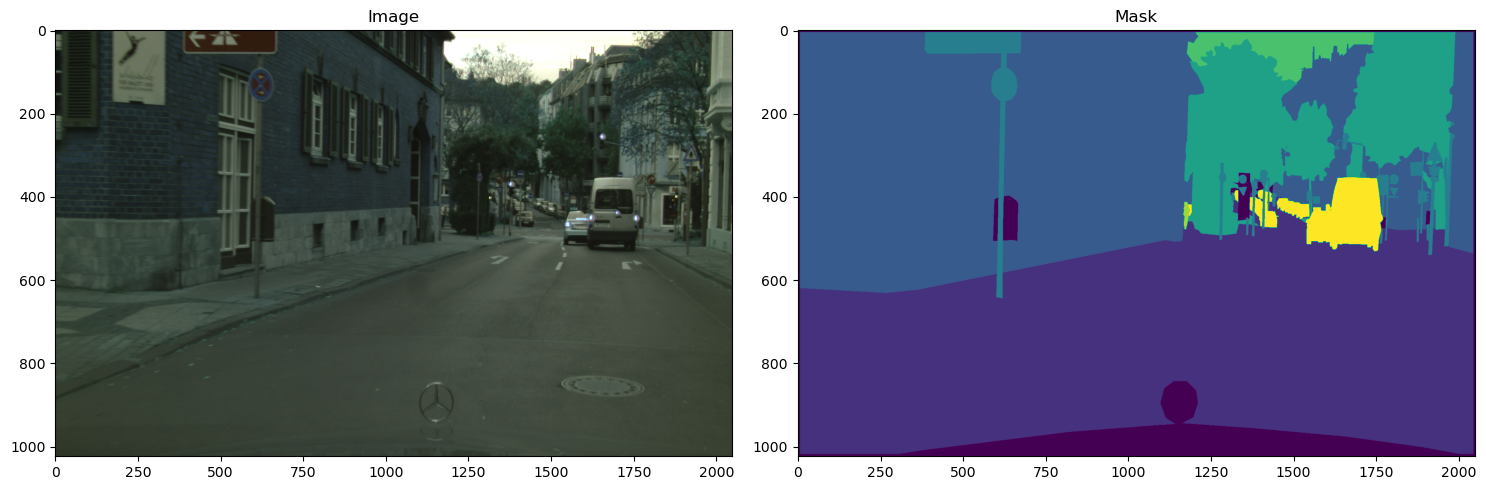

In [105]:
train_image_dir = "data/train/images"
train_mask_dir = "data/train/gen_masks"
val_image_dir = 'data/val/images'
val_mask_dir = 'data/val/gen_masks'

#visualize image and mask before transformation
img_path = os.path.join(train_image_dir, os.listdir(train_image_dir)[1])
mask_path = os.path.join(train_mask_dir, os.listdir(train_mask_dir)[1])
img = cv2.imread(img_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(1, 2, figsize=(15, 5)) #set 2 columns to examine differences between originals and modifications

ax[0].imshow(img, aspect='auto')
ax[0].set_title("Image")

ax[1].imshow(mask, aspect='auto')
ax[1].set_title("Mask")

plt.tight_layout()
plt.show()

In [106]:
#prepare transformation from documentation
pipeline = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5), # 50% chance to flip
    A.RandomBrightnessContrast(p=0.8), # 80% chance to adjust brightness/contrast
    A.GaussianBlur(p=0.3), # 30% chance to blur
])

transformed_data = pipeline(image=img, mask=mask)

#transformed_data['image']

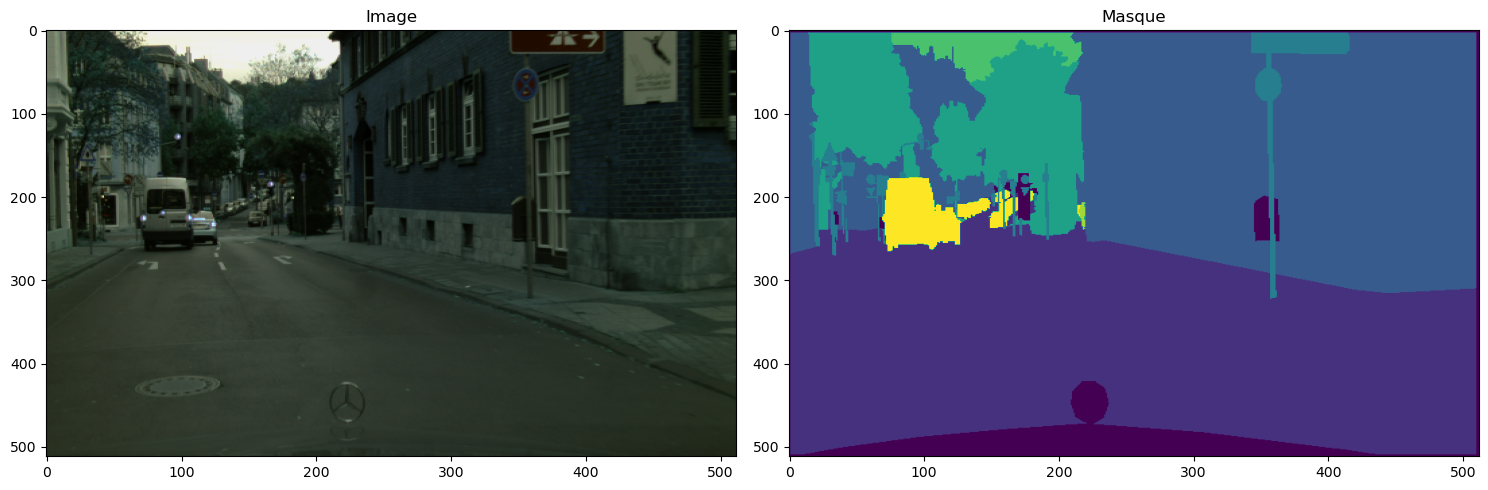

In [107]:
new_img=transformed_data['image']
new_mask=transformed_data['mask']

#visualize images and masks
fig, ax = plt.subplots(1, 2, figsize=(15, 5)) #set 2 columns to examine differences between originals and modifications
ax[0].imshow(new_img, aspect='auto')
ax[0].set_title("Image")

ax[1].imshow(new_mask, aspect='auto')
ax[1].set_title("Masque")

"""ax[0].imshow(img, aspect='auto') 
ax[0].set_title("Image")

ax[1].imshow(mask, aspect='auto')
ax[1].set_title("Masque")"""

plt.tight_layout()
plt.show()

Need to expriment on : 
- A.togray or A.ChannelDropout : in order to avoid model dependance to colors
- A.affine : for multiple geometric transformation at once

Take it out to a dedicated notebook ! 

### Treating and comparing results

In [110]:
#loading all models
model_VGG16 = keras.models.load_model('models_in_progress/first_model.keras')
model_VGG16_LR = keras.models.load_model('models_in_progress/second_model.keras')
model_ResNet50 = keras.models.load_model('models_in_progress/resnet_model.keras')
model_InceptionV3 = keras.models.load_model('models_in_progress/inception_model.keras')

#evaluate all models
result_VGG16 = model_VGG16.evaluate(X_val, y_val, return_dict=True)
result_VGG16_lower_LR = model_VGG16_LR.evaluate(X_val, y_val, return_dict=True)
result_ResNet50 = model_ResNet50.evaluate(X_val, y_val, return_dict=True)
result_InceptionV3 = model_InceptionV3.evaluate(X_val, y_val, return_dict=True)

2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 13s/step - accuracy: 0.8664 - iou: 0.7646 - loss: 20.5005
2/2 ━━━━━━━━━━━━━━━━━━━━ 44s 13s/step - accuracy: 0.1116 - iou: 0.0535 - loss: 49.0404
2/2 ━━━━━━━━━━━━━━━━━━━━ 25s 7s/step - accuracy: 0.1780 - iou: 0.0000e+00 - loss: 48.4340
2/2 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - accuracy: 0.8918 - iou: 0.8057 - loss: 19.4845


In [111]:
inceptionv3_train_time

23935.57458972931

In [112]:
#adding train time to each dict
result_VGG16["train_time"] = vgg16_train_time
result_VGG16_lower_LR["train_time"] = vgg16_lower_LR_train_time
result_ResNet50["train_time"] = resnet_train_time
result_InceptionV3["train_time"] = inceptionv3_train_time

result_dict = {
    "result_VGG16": result_VGG16,
    "result_VGG16_lower_LR": result_VGG16_lower_LR,
    "result_ResNet50": result_ResNet50,
    "result_InceptionV3": result_InceptionV3
}
result_dict

{'result_VGG16': {'accuracy': 0.8730527758598328,
  'iou': 0.7749502062797546,
  'loss': 20.229248046875,
  'train_time': 48590.184636592865},
 'result_VGG16_lower_LR': {'accuracy': 0.11228683590888977,
  'iou': 0.05383491888642311,
  'loss': 49.004127502441406,
  'train_time': 8832.635286331177},
 'result_ResNet50': {'accuracy': 0.17189209163188934,
  'iou': 0.0,
  'loss': 48.471824645996094,
  'train_time': 4466.901176929474},
 'result_InceptionV3': {'accuracy': 0.8976255655288696,
  'iou': 0.8151187300682068,
  'loss': 19.217866897583008,
  'train_time': 23935.57458972931}}

In [113]:
result_df = pd.DataFrame.from_dict(result_dict, orient='index')
print(result_df)

                       accuracy       iou       loss    train_time
result_VGG16           0.873053  0.774950  20.229248  48590.184637
result_VGG16_lower_LR  0.112287  0.053835  49.004128   8832.635286
result_ResNet50        0.171892  0.000000  48.471825   4466.901177
result_InceptionV3     0.897626  0.815119  19.217867  23935.574590


Here we can see that all encoders have similar capacities, but a reduced LR seems to improve results